# TUTORIAL 01 : CAISO OASIS Renewables

## Renewables and emissions reports

_... renewables reports provide important information about actual renewable 
energy within the ISO grid as California moves towards a 33 percent 
renewable generation portfolio._
</br>
_See: http://www.caiso.com/market/Pages/ReportsBulletins/RenewablesReporting.aspx_

### CAISO Links

* [Daily Renewables Watch](http://content.caiso.com/green/renewrpt/DailyRenewablesWatch.pdf)
* [CAISO Interface Specification](http://www.caiso.com/Documents/OASIS-InterfaceSpecification_v5_1_8Clean_Independent2019Release.pdf#search=Interface%20Specification)
* [Wind Solar RTD & Curtailment](http://www.caiso.com/Documents/Wind_SolarReal-TimeDispatchCurtailmentReportOct21_2019.pdf#search=Real%20Time%20Dispatch)

### Local Files
* [Daily Renewables Watch](./docs/DailyRenewablesWatch.pdf)
* [CAISO Interface Specification](./docs/OASIS-InterfaceSpecification_v5_1_8Clean_Independent2019Release.pdf)
* [Wind Solar RTD & Curtailment](./docs/Wind_SolarReal-TimeDispatchCurtailmentReportOct21_2019.pdf)

In [34]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Create the connection to the unzipped database in this directory
cnx  = sqlite3.connect(r'./data-oasis-ene-wind-solar-summary_00.db')

In [ ]:
# make graphs look modern and pretty
import seaborn as sns
sns.set()

In [31]:
# cribbed from Brandon Rhodes' tutorials
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [25]:
# Read the database into a dataframe by joining report_header with report_data 
df = pd.read_sql("select report_data.data_item, report_data.value, report_header.uom, report_header.report, report_header.mkt_type, report_data.interval_start_gmt, report_data.interval_end_gmt from report_header inner join report_data on report_header.report_item_id = report_data.report_item_id;", cnx)

# Convert gmt time strings to pandas datetime
df['interval_start_ts'] = pd.to_datetime(df['interval_start_gmt'])
df['interval_end_ts'] = pd.to_datetime(df['interval_end_gmt'])

# Drop unnec gmt columns
df.drop(['interval_start_gmt', 'interval_end_gmt'], axis='columns', inplace=True)

# Set the index to be the start timestamp
df = df.set_index('interval_start_ts', drop=True)
df.head()

,data_item,value,uom,report,mkt_type,interval_end_ts
interval_start_ts,,,,,,
2016-11-15 07:00:00+00:00,DAM_FORECAST,364.00,MW,ENE_WIND_SOLAR_SUMMARY,DAM,2016-11-15 08:00:00+00:00
2016-11-15 07:00:00+00:00,DAM_NET_VIRTUAL,453.00,MW,ENE_WIND_SOLAR_SUMMARY,DAM,2016-11-15 08:00:00+00:00
2016-11-15 07:00:00+00:00,DAM_SCHEDULE,173.00,MW,ENE_WIND_SOLAR_SUMMARY,DAM,2016-11-15 08:00:00+00:00
2016-11-15 07:00:00+00:00,RTM_SCHEDULE,311.42,MW,ENE_WIND_SOLAR_SUMMARY,RTD,2016-11-15 08:00:00+00:00
2016-11-15 08:00:00+00:00,DAM_FORECAST,612.00,MW,ENE_WIND_SOLAR_SUMMARY,DAM,2016-11-15 09:00:00+00:00


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140370 entries, 2016-11-15 07:00:00+00:00 to 2019-10-18 06:00:00+00:00
Data columns (total 6 columns):
data_item          140370 non-null object
value              140370 non-null float64
uom                140370 non-null object
report             140370 non-null object
mkt_type           140370 non-null object
interval_end_ts    140370 non-null datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(1), object(4)
memory usage: 7.5+ MB


In [22]:
df.data_item.unique()

array(['DAM_FORECAST', 'DAM_NET_VIRTUAL', 'DAM_SCHEDULE', 'RTM_SCHEDULE'],
      dtype=object)

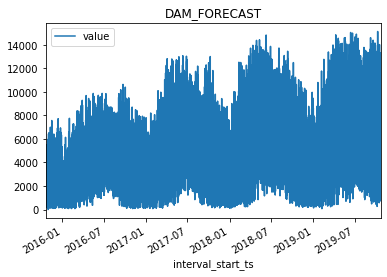

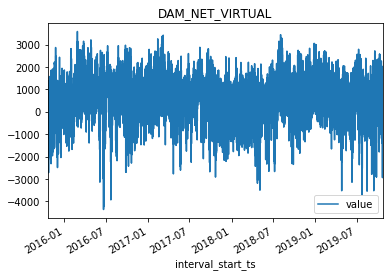

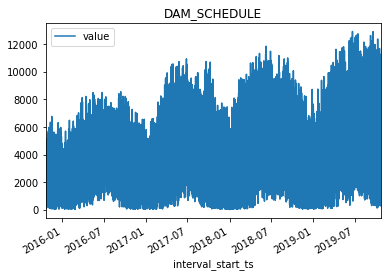

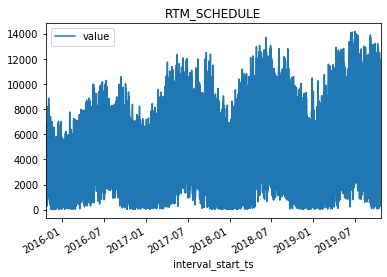

In [33]:
for title, group in df.groupby(['data_item']):
    group.plot.line(y='value', title=title)

In [5]:
df.dtypes

data_item            object
value               float64
uom                  object
report               object
mkt_type             object
interval_end_gmt     object
dtype: object

In [6]:
df1 = sdf("select ts, value from df where data_item = 'RTM_SCHEDULE';")
df1['ts'] = pd.to_datetime(df1['ts'])
df1 = df1.set_index('ts')
df1.head()

,value
ts,
2016-11-15 07:00:00,311.42
2016-11-15 08:00:00,383.00
2016-11-15 09:00:00,574.58
2016-11-15 10:00:00,761.17
2016-11-15 11:00:00,871.50


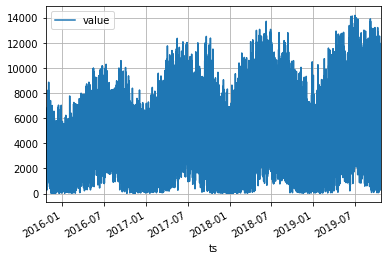

In [7]:
df1.plot(grid=True)

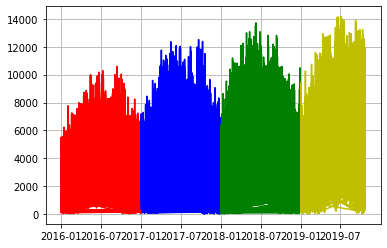

In [8]:
import datetime
d1 = datetime.datetime(2016,1,1)
d2 = datetime.datetime(2017,1,1)
d3 = datetime.datetime(2018,1,1)
d4 = datetime.datetime(2019,1,1)
d5 = datetime.datetime(2020,1,1)
y1 = df1[(d1 <= df1.index) & (df1.index < d2)]
y2 = df1[(d2 <= df1.index) & (df1.index < d3)]
y3 = df1[(d3 <= df1.index) & (df1.index < d4)]
y4 = df1[(d4 <= df1.index) & (df1.index < d5)]

fig, ax = plt.subplots()
ax.grid(True)
plt.plot(y1, c='r')
plt.plot(y2, c='b')
plt.plot(y3, c='g')
plt.plot(y4, c='y')

## Acronyms

### DAM : Day Ahead Market

http://www.ercot.com/mktinfo/dam/

    Day-Ahead Market

    The Day-Ahead Market (DAM) is a voluntary, financially-binding forward energy market. The DAM matches willing buyers and sellers, subject to network security and     other constraints, whereby energy is co-optimized with Ancillary Services and certain Congestion Revenue Rights. It provides a platform to hedge congestion costs in the day-ahead of the Operating Day, and instruments to mitigate the risk of price volatility in Real-Time.


### RTM : Real Time Market

http://www.ercot.com/mktinfo/rtm

    Real-Time Market

    During real-time, ERCOT dispatches resources based on economics and reliability to meet the system demand while observing resource and transmission constraints. Security Constrained Economic Dispatch (SCED) is the real-time market evaluation of offers to produce a least-cost dispatch of online resources. SCED calculates Locational Marginal Prices (LMPs) using a two-step methodology that applies mitigation to resolve non-competitive constraints.

### RTD : Real Time Dispatch